# Power grid example model definition
We considere the following power grid taken from [a CIGRE network](http://www.cigre.org/News/Network-of-the-Future) described by the following picture

<img src="https://pandapower.readthedocs.io/en/v1.4.1/_images/cigre_network_lv.png" alt="Model" style="width: 500px;"/>

A model of this network can be created using pandapower as follow:

In [1]:
import pandapower as pp
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import pandapower.plotting as pp_plot
 
net = pp.create_empty_network()

In [2]:
data_power_grid_folder = "PowerGridData"

for i in ["bus", "bus_geodata", "line", "switch", "trafo", "ext_grid", "load","line_geodata"]:
    df = pd.DataFrame(json.load(open(os.path.join(data_power_grid_folder,'{}.json'.format(i)))))
    df.index = map(int, df.index)
    setattr(net, i, df)

In [3]:
df=pd.read_csv('..\..\TEsimulation\AddFiles\Blocks_data.csv',sep=';')
buildings = list(df)[2::]
EA_Pel_unit = pd.read_csv("..\..\TEsimulation\AddFiles\SK90_eload_m2.csv",sep=';')

loads = pd.DataFrame(json.load(open(os.path.join(data_power_grid_folder, 'load.json'))))
loads.index = map(int, loads.index)
loads.head()

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load_AA,30,0,0,0.0,0.0,None,1.0,True,None
1,Load_BB,31,0,0,0.0,0.0,None,1.0,True,None
10,Load_C,40,0,0,0.0,0.0,None,1.0,True,None
11,Load_D,41,0,0,0.0,0.0,None,1.0,True,None
12,Load_E,42,0,0,0.0,0.0,None,1.0,True,None


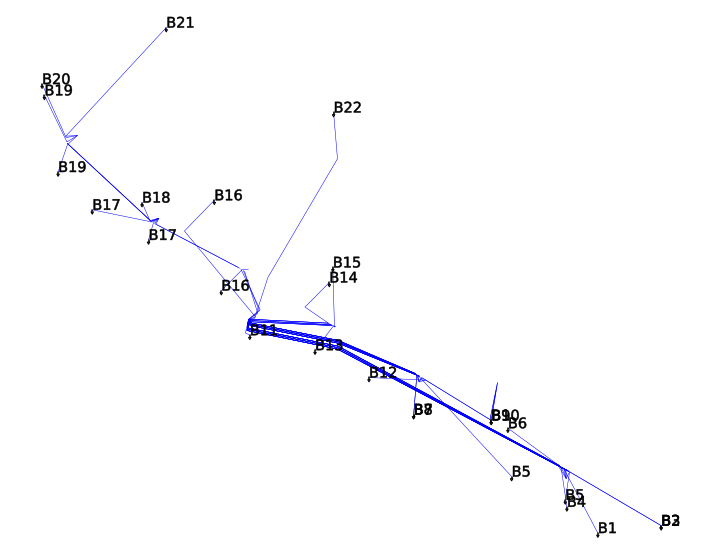

In [4]:
#pp_plot.simple_plot(net) # It plots everything
lineList = []
loadList = []
loadList_name = []
load_coords_vector = []
for building in buildings:

    #paths to simulation output files#
    eflowsFileDR = "..\..\TEsimulation\Results\Files\{}\EnergyFlows.csv".format(building)
    eflowsDataDR = pd.read_csv(eflowsFileDR)                                                    

    slines = df[building][14].split(',') # Spilt the loads    
    for sline in slines:# Create as many outlets as connection points    
        lineInd = net.line.loc[net.line['name']==sline].index.values
        lineList = lineList + [float(lineInd)]
         
        
    cpoints = df[building][7].split(',') # Spilt the loads    
    for cpoint in cpoints:# cpoint is the name of the load!!
        loadInd = net.load.loc[net.load['name']==cpoint].index.values
        loadList = loadList + [int(loadInd)]
        loadList_name = loadList_name + [building]



        bus_index = net.load.bus.loc[loadInd] # this returns the corresponding bus index    
        load_coords = net.bus_geodata.loc[bus_index] # this returns the coordinates    
        load_coords_tuple = (load_coords.x,load_coords.y)# I need to put them in a vector
        load_coords_vector = list(load_coords_vector)
        load_coords_vector.append(load_coords_tuple) 
    
lic = pp_plot.create_line_collection(net, lines=lineList, zorder = 1,color = 'b',linewidths = 0.5)
loc = pp_plot.create_load_collection(net, loadList, zorder = 2)
loc_name = pp_plot.create_annotation_collection(texts = loadList_name , coords = load_coords_vector, size = 10, color = 'k',linewidths = 0.5, zorder = 3)
pp_plot.draw_collections([lic,loc,loc_name])
#pp_plot.draw_collections([lic,loc])
#plt.savefig("CaseStudy.png")

In [5]:
# 2000-02-07  18:30:00 - 1816 
for building in buildings:

    #paths to simulation output files#
    eflowsFileDR = "..\..\TEsimulation\Results\Files\{}\EnergyFlows.csv".format(building)
    eflowsDataDR = pd.read_csv(eflowsFileDR)
    idate = 1812 # eflowsDataDR.iloc[1812,0] is 2000-02-07 18:30
                                                                          
    newLoadHP = eflowsDataDR.loc[idate, 'HP_Pel_kW']
    newLoadEB = eflowsDataDR.loc[idate, 'EB_Pel_kW']
    newLoadEA = EA_Pel_unit['Pel_ea_m2'][907] * float(df[building][3])                                                                
    newLoad = newLoadHP + newLoadEB + newLoadEA # kW                                                                          
                                                                          
    cpoints = df[building][7].split(',') # Spilt the loads
    for cpoint in cpoints:# cpoint is the name of the load!!
        loadInd = net.load.loc[net.load['name']==cpoint].index.values
        net.load.loc[loadInd,'p_mw'] = newLoad/1000/len(cpoints) # MW                                                                 
        net.load.loc[loadInd,'q_mva'] = newLoad/1000/len(cpoints) * 0.1          

In [6]:
pp.runpp(net, numba=False)

c:\users\arnaudo\envs\zero365\lib\site-packages\pandapower\build_branch.py:375: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  phase_shifters = tap_phase_shifter & (tap_side == side)
c:\users\arnaudo\envs\zero365\lib\site-packages\pandapower\build_branch.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  tap_complex = np.isfinite(tap_step_percent) & np.isfinite(tap_pos) & (tap_side == side) & \


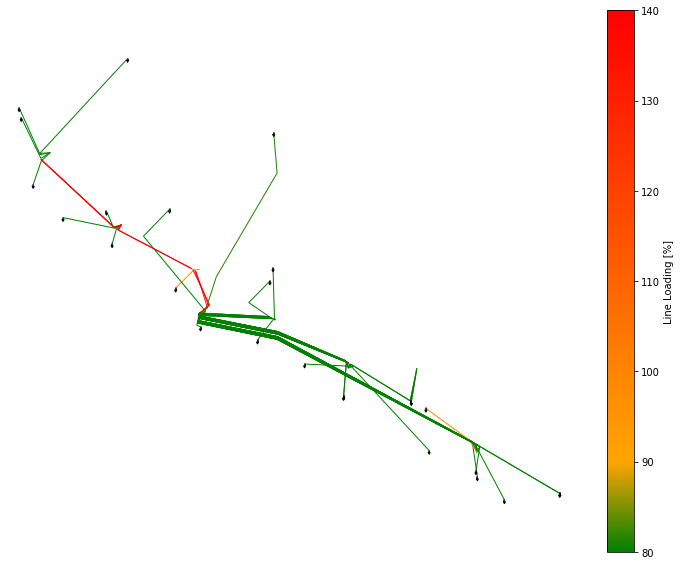

In [23]:
cmap_list=[(80, "green"), (90, "orange"), (140, "red")]
cmap, norm = pp_plot.cmap_continuous(cmap_list) 
#bc = plt.create_bus_collection(net, net.bus.index, size=80, zorder=2, cmap=cmap, norm=norm)
#lc = plt.create_line_collection(net, net.line.index, size=80, zorder=2, cmap=cmap, norm=norm)
#plot.draw_collections([lc, bc], figsize=(8,6))

lic = pp_plot.create_line_collection(net, lines=lineList, zorder = 2,cmap=cmap, norm=norm,linewidths = 1)
loc = pp_plot.create_load_collection(net, loadList,zorder = 2,norm=norm)
pp_plot.draw_collections([lic,loc])
plt.savefig("CaseStudy_criticalPP.png")